In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from plotly.subplots import make_subplots
import doctest

In [3]:
# A smaller csv from the US Census for testing formatting and cleaning functions
small_test = pd.read_csv("data/small_census_test.csv")
small_test.head(5)

,Label (Grouping),Washington!!Total!!Estimate,Washington!!Percent!!Estimate,"Franklin County, Washington!!Percent of specified language speakers!!Speak English only or speak English ""very well""!!Estimate","Franklin County, Washington!!Percent of specified language speakers!!Percent speak English only or speak English ""very well""!!Estimate"
0,Population 5 years and over,"7,248,377",(X),"68,081",76.9%
1,Speak only English,"5,758,942",79.5%,(X),(X)
2,Speak a language other than English,"1,489,435",20.5%,"23,043",53.0%
3,SPEAK A LANGUAGE OTHER THAN ENGLISH,NaN,NaN,NaN,NaN
4,Spanish,"629,881",8.7%,"21,168",53.1%


In [9]:
def clean(series):
    '''
    A function to clean columns in a dataframe to all lowercase strings.
    Returns a cleaned list of the given column.

    >>> clean(pd.Series(["UPPERCASE", "low", "UPandLow"]))
    ['uppercase', 'low', 'upandlow']
    >>> clean(small_test["Label (Grouping)"].head(2))
    ['population 5 years and over', '\xa0\xa0\xa0\xa0speak only english']
    '''
    cleaned = []
    for row in series:
        cleaned.append(str(row).lower())
    return cleaned

def clean_df(df):
    '''
    A function to clean column_name in a dataframe to all lowercase strings,
    cleans whitespace, and replaces within-name whitespace with underscores.
    Returns a dataframe.

    >>> clean_df(reformat_census_df(small_test, 3)).columns.tolist()[1:4]
    ['speak_only_english', 'speak_a_language_other_than_english', 'speak_a_language_other_than_english']
    >>> clean_df(small_test).columns.tolist()[2]
    'washington!!percent!!estimate'
    '''
    df = df.copy(deep=True)
    df.columns = [name.strip().lower().replace(' ','_') for name in df.columns]
    return df

def reformat_census_df(df, num_levels):
    '''
    Returns a reformatted US census dataframe, with multi-indexes.
    This function only takes in US census csv data, and must meet these requirements.
    - The faux-index is named "Label (Grouping)"
    - Faux-index includes one string of a multi-index, with '!!' as the delimiter
    - Has a County and Ratio equivalent within the multi-index levels
        - Ratio label type example: Estimate, percent

    >>> reformat_census_df(clean_df(small_test), 3).index[1]
    ('washington', 'percent')
    >>> reformat_census_df(small_test, 3).index.get_level_values(1).tolist()
    ['Total', 'Percent']
    '''
    df = df.copy(deep=True)
    if "label_(grouping)" in df.columns:
        df.set_index("label_(grouping)", inplace=True)
    else:
        df.set_index("Label (Grouping)", inplace=True)
    df = df.transpose()
    df['temp_index'] = df.index
    regex_pattern = r"^[\w,\s]+"
    for i in range(num_levels - 1):
        regex_pattern += "\!\![\w,\s]+"
    regex_pattern += "$"
    df = df.loc[df['temp_index'].str.contains(regex_pattern)]
    df.insert(0, "County", "")
    df.insert(1, "Ratio", "")

    for row in df['temp_index']:
        terms = row.split("!!")
        terms[0] = terms[0].split(",")[0]
        df.loc[row, ['County']] = terms[0]
        df.loc[row, ['Ratio']] = terms[1]

    df.rename_axis(None, axis=1, inplace=True)
    df.set_index(['County', 'Ratio'], inplace=True)
    df.drop(columns=['temp_index'], inplace=True, axis=1)
    return df

doctest.testmod()

TestResults(failed=0, attempted=6)

In [10]:
clean_df(small_test).columns.tolist()[2]

'washington!!percent!!estimate'

 1. How does language diversity in each Washington county affect their educational attainment outcomes?


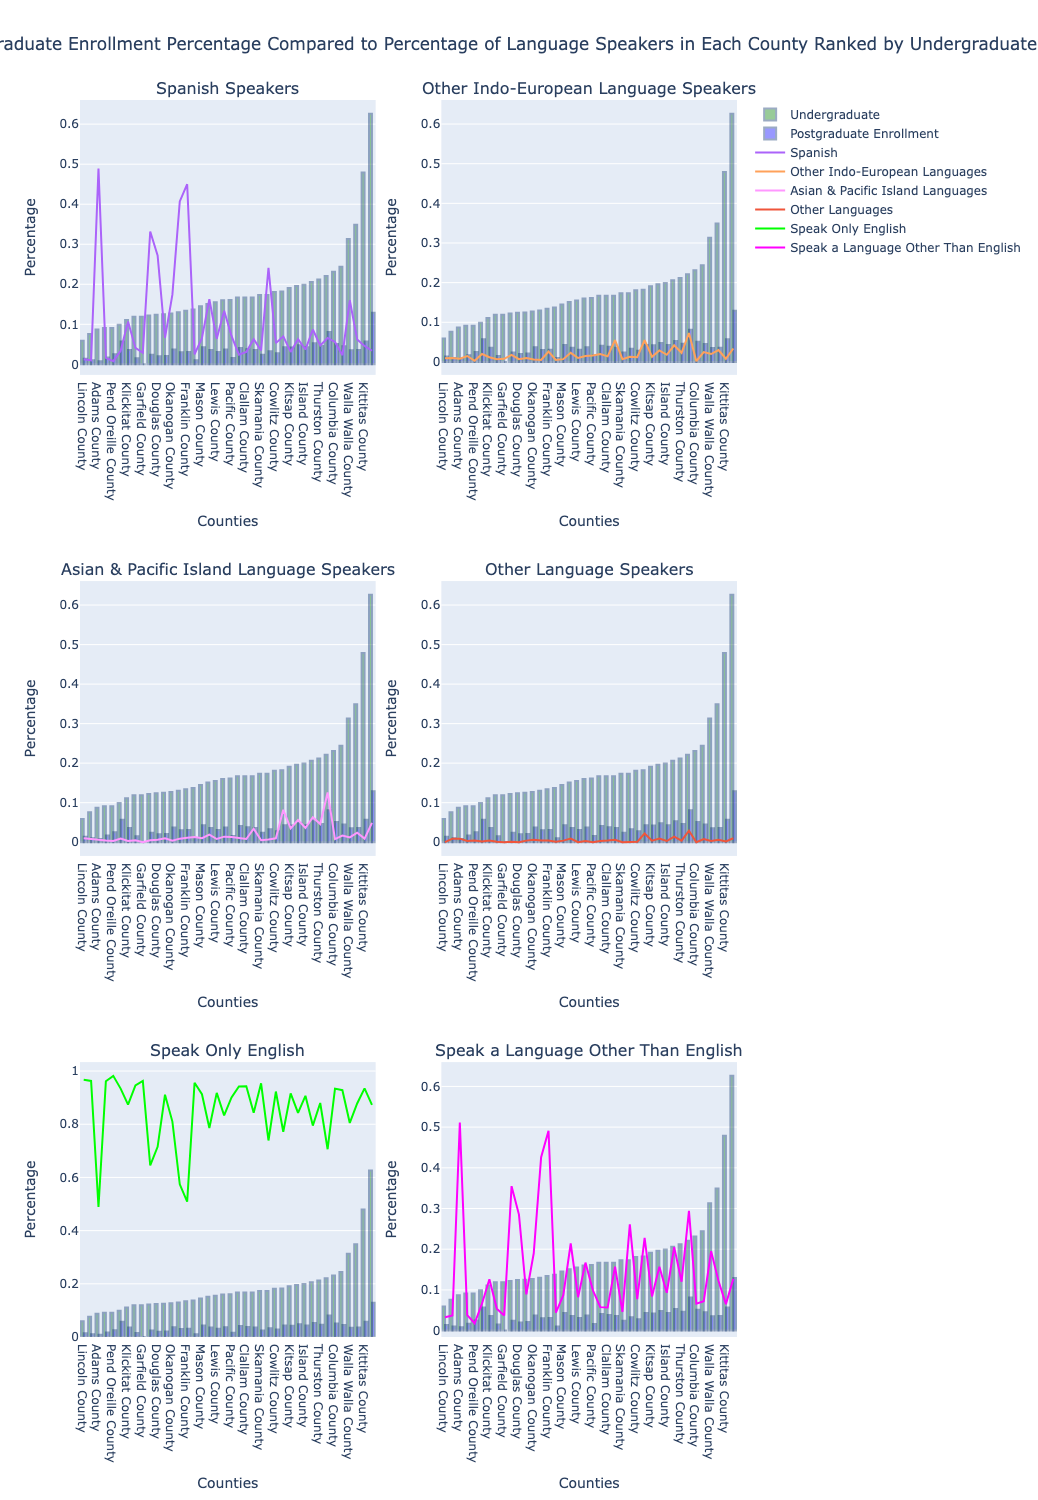

In [30]:
language_demographic = pd.read_csv("data/S1601LanguagesSpokenAtHome.csv")
language_demographic = reformat_census_df(language_demographic, 3)
language_demographic = clean_df(language_demographic)

enrollment = pd.read_csv("data/S1401SchoolEnrollment.csv")
enrollment = reformat_census_df(enrollment, 3)
enrollment = clean_df(enrollment)

language_demographic = language_demographic.loc[
    (language_demographic.index.get_level_values("County"), "Percent"), :]
enrollment = enrollment.loc[(enrollment.index.get_level_values("County"), "Percent"), :]

sub_language = language_demographic.iloc[:, [1, 2, 4, 8, 12, 16]].apply(lambda x: x.str.replace('%','').astype(float) / 100)
sub_enrollment = enrollment.iloc[:, [7, 8]].apply(lambda x: 
                                                  x.str.replace('%','').astype(float) / 100)

new = pd.merge(sub_enrollment, sub_language, on=['County'])
new = new.sort_values(by="college,_undergraduate")

all_lang_colors = ['#AB63FA', '#FFA15A', "#FF97FF", "#EF553B", 'lime', 'magenta']

fig1 = make_subplots(3,2, subplot_titles=('Spanish Speakers',  'Other Indo-European Language Speakers', 
                                         'Asian & Pacific Island Language Speakers', 'Other Language Speakers',
                                         'Speak Only English', 'Speak a Language Other Than English'))

names = {"spanish": "Spanish", "other_indo-european_languages": "Other Indo-European Languages",
         "asian_and_pacific_island_languages": "Asian & Pacific Island Languages", "other_languages": "Other Languages",
         "speak_only_english": "Speak Only English", "speak_a_language_other_than_english": "Speak a Language Other Than English"}

for (i, j), type, color, bool in zip([(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2)], 
                                     ["spanish", "other_indo-european_languages", "asian_and_pacific_island_languages", 
                                      "other_languages", "speak_only_english", "speak_a_language_other_than_english"], 
                                     all_lang_colors,
                                     [True, False, False, False, False, False]):
       fig1.add_trace(go.Bar(x=new.index, y=new['college,_undergraduate'],
                            name='Undergraduate',
                            showlegend=bool,
                            marker_color = 'green',
                            opacity=0.4,
                            marker_line_color='rgb(8,48,107)',
                            marker_line_width=2),
                     row = i, col = j)
       fig1.add_trace(go.Bar(x=new.index, y=new['graduate,_professional_school'],
                            name='Postgraduate Enrollment', 
                            showlegend=bool,                  
                            marker_color = 'blue',                     
                            opacity=0.4,
                            marker_line_color='rgb(8,48,107)',
                            marker_line_width=2),
                     row = i, col = j)
       fig1.add_trace(go.Scatter(x=new.index, y=new[type], line=dict(color=color), name=names[type]), row = i, col = j)
       
fig1.update_layout(autosize=False, width=3000, height=1500, 
                  title_text="Undergraduate & Postgraduate Enrollment Percentage Compared to Percentage of Language Speakers in Each County"
                            + " Ranked by Undergraduate Enrollment",
                  title_x=0.45, xaxis_title="Counties", yaxis_title="Percentage")

for i in range(1, 7):
       fig['layout'][f"xaxis{i}"]['title']='Counties'
       fig['layout'][f"yaxis{i}"]['title']='Percentage'

fig1.show()
       
# Undergraduate data
assert sorted(fig1.to_dict()['data'][0]['y']) == sorted(
    sub_enrollment[
        'college,_undergraduate'].tolist()), "Undergrad data does not match expected"
# Postgrad data
assert sorted(fig1.to_dict()['data'][1]['y']) == sorted(sub_enrollment['graduate,_professional_school'].tolist()), "Postgrad data does not match expected"
# Spanish data
assert sorted(fig1.to_dict()['data'][2]['y']) == sorted(sub_language['spanish'].tolist()), "Spanish data does not match expected"
# Indo-Euro data
assert sorted(fig1.to_dict()['data'][5]['y']) == sorted(sub_language['other_indo-european_languages'].tolist()), "Indo-European data does not match expected"
# Asian data
assert sorted(fig1.to_dict()['data'][8]['y']) == sorted(sub_language['asian_and_pacific_island_languages'].tolist()), "Asian & Pacific Islander data does not match expected"
# Other data
assert sorted(fig1.to_dict()['data'][11]['y']) == sorted(sub_language['other_languages'].tolist()), "Other language data does not match expected"
# English data
assert sorted(fig1.to_dict()['data'][14]['y']) == sorted(sub_language['speak_only_english'].tolist()), "English data does not match expected"
# Other than English data
assert sorted(fig1.to_dict()['data'][17]['y']) == sorted(sub_language['speak_a_language_other_than_english'].tolist()), "Other than English data does not match expected"
# Counties
assert sorted(fig1.to_dict()['data'][0]['x']) == sorted(enrollment.index.get_level_values('County')), "Counties not accounted for"

2. how do school district budgets and spending affect spoken langugae diversity in WA counties?

In [12]:
ppe = pd.read_csv('data/SchoolDistrictPPEAverages.csv')
ppe = clean_df(ppe)
ppe['districtname'] = clean(ppe['districtname'])
counties = pd.read_csv("data/Counties.csv", header=2)
counties = counties.loc[counties["State Postal Code"] == "WA"]
counties = clean_df(counties)
counties['school_district_name'] = clean(counties['school_district_name'])

counties_ppe = ppe.merge(counties, right_on="school_district_name", left_on="districtname")
counties_ppe.set_index('school_district_name', inplace=True)
counties_ppe.drop(columns=['districtname'], inplace=True)

ppe_languages = counties_ppe[["ppe", "county_names"]].groupby("county_names").mean()
ppe_languages['County'] = ppe_languages.index
ppe_languages = ppe_languages.merge(sub_language, left_on="county_names", right_on="County")
ppe_languages.set_index('County', inplace=True)

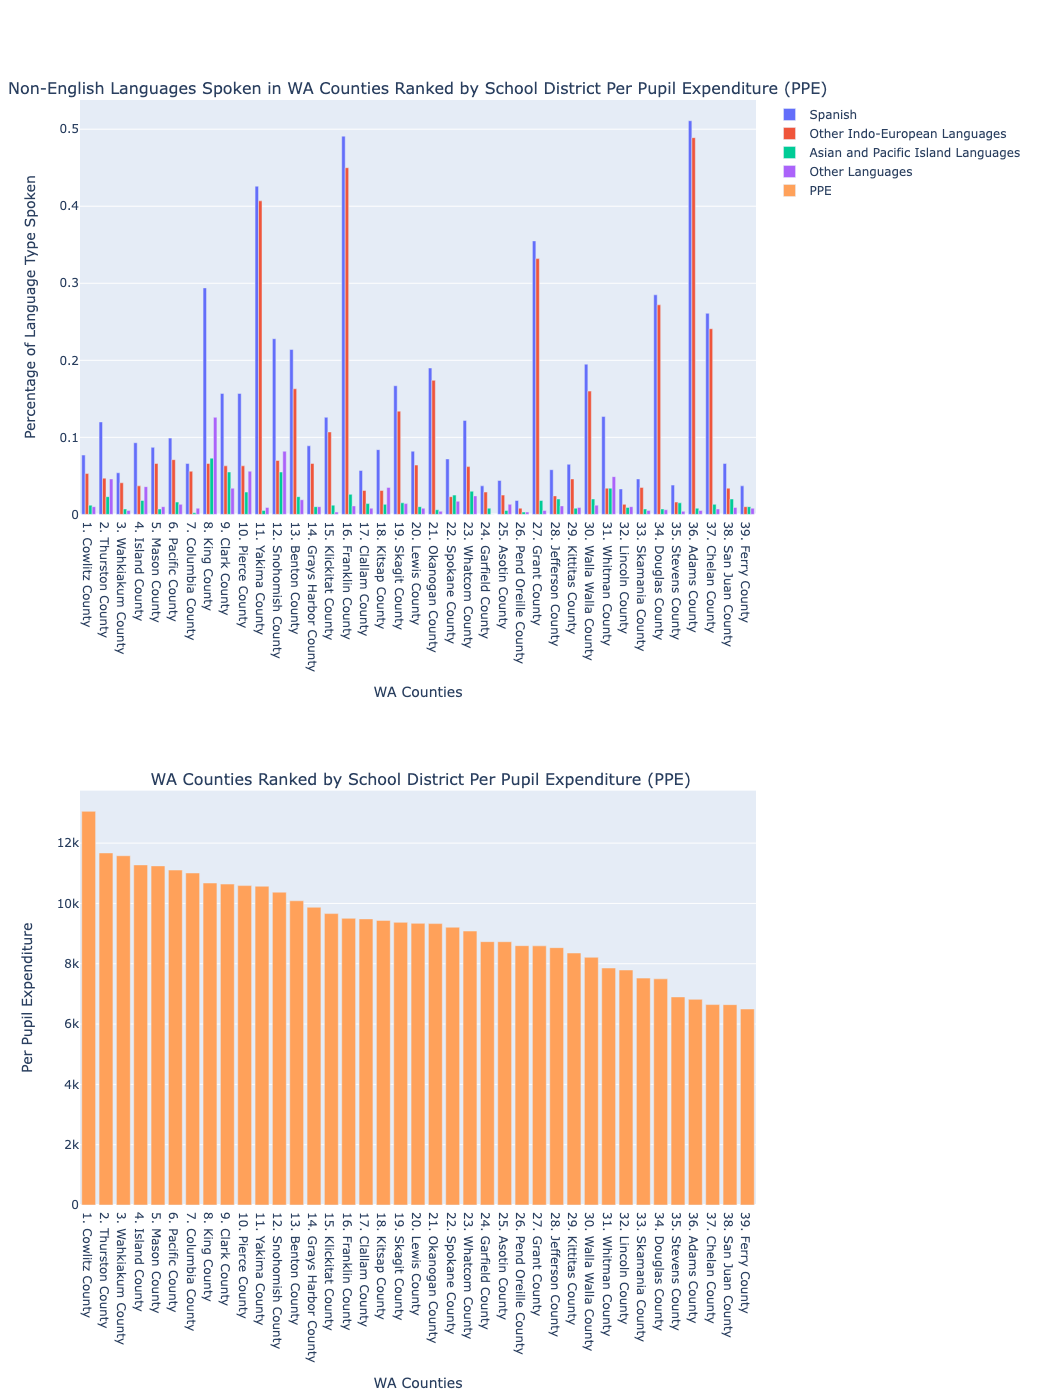

In [13]:
ppe_languages = ppe_languages.sort_values(by='ppe', ascending=False)
all_lang_colors = ['#636EFA', '#EF553B', "#00CC96", "#AB63FA", "#FFA15A"]
all_counties = []
for i in range(len(ppe_languages.index)):
    all_counties.append(str(i + 1) + ". " + ppe_languages.index[i])
all_lang_types = ppe_languages.iloc[:, 2:].columns
all_lang_labels = ['Spanish', 'Other Indo-European Languages', 'Asian and Pacific Island Languages', 'Other Languages']
fig2 = make_subplots(2, 1, subplot_titles=('Non-English Languages Spoken in WA Counties Ranked by School District Per Pupil Expenditure (PPE)',  
                                          ' WA Counties Ranked by School District Per Pupil Expenditure (PPE)'))

for i in range(len(all_lang_labels)):
    fig2.add_trace(go.Bar(x=all_counties,
                    y=ppe_languages[all_lang_types[i]],
                    name=all_lang_labels[i],
                    marker_color=all_lang_colors[i]
                    ), row = 1, col = 1)
fig2.add_trace(go.Bar(x=all_counties,
                y=ppe_languages['ppe'],
                name='PPE',
                marker_color=all_lang_colors[4]
                ), row = 2, col = 1)
fig2.update_layout(autosize=False, width=1300, height=1400)
fig2['layout']['xaxis']['title']='WA Counties'
fig2['layout']['xaxis2']['title']='WA Counties'
fig2['layout']['yaxis']['title']='Percentage of Language Type Spoken'
fig2['layout']['yaxis2']['title']='Per Pupil Expenditure'

fig2.show()

# Testing for all counties included and are sorted by the PPE
ppe_languages_sorted = ppe_languages.sort_values(by='ppe', ascending=False).index
for i in range(len(fig2.to_dict()['data'])):
    all_labels = fig2.to_dict()['data'][i]['x']
    for label, idx in zip(all_labels, ppe_languages_sorted):
        assert(label.split(' ', 1)[1] == idx), "Data does not match expected"

3. To what extent do Washington residents continue to practice their ancestral culture through language?
- We chose to first look at the demographic distribution as a percentage of people who identified as non-American. 
Then we ran a linear regression to measure how strong this relationship was, between the the diversity rate (non-American)of a county and the rate at which English is only used in households.

In [14]:
households = pd.read_csv("data/DP02AncestryLanguagesSpokenAtHome.csv")
households = reformat_census_df(households, 2)
households = clean_df(households)

In [15]:
# getting the total diversity for non-American ancestry

ancestry_backgrounds = households.iloc[:, -32:-4].copy().loc[(households.index.get_level_values("County"), "Estimate"), :]
ancestry_backgrounds = ancestry_backgrounds.apply(lambda x: x.str.replace(',','').astype(float))
ancestry_backgrounds.columns = [name.strip() for name in ancestry_backgrounds.columns]


diverse_count = []
full_count = [x.sum() for _, x in ancestry_backgrounds.iterrows()]
for _, row in ancestry_backgrounds.iloc[:, 1:].iterrows():
    diverse_count.append(row.sum())

ancestry_backgrounds['diversity_ratio'] = [x / y for x, y in zip(diverse_count, full_count)]

In [16]:
# getting the languages being used in each household
lang_usages = households.iloc[:, -45:-33].copy().loc[(households.index.get_level_values("County"), "Percent"), :]
ancestry_backgrounds.index = ancestry_backgrounds.index.droplevel(1)
lang_usages.index = lang_usages.index.droplevel(1)
diverse_lang = pd.DataFrame(ancestry_backgrounds['diversity_ratio']).merge(lang_usages, right_index=True, left_index=True)
diverse_lang.iloc[:, 2:] = diverse_lang.iloc[:, 2:].apply(lambda x: x.str.replace('%','').astype(float) / 100)

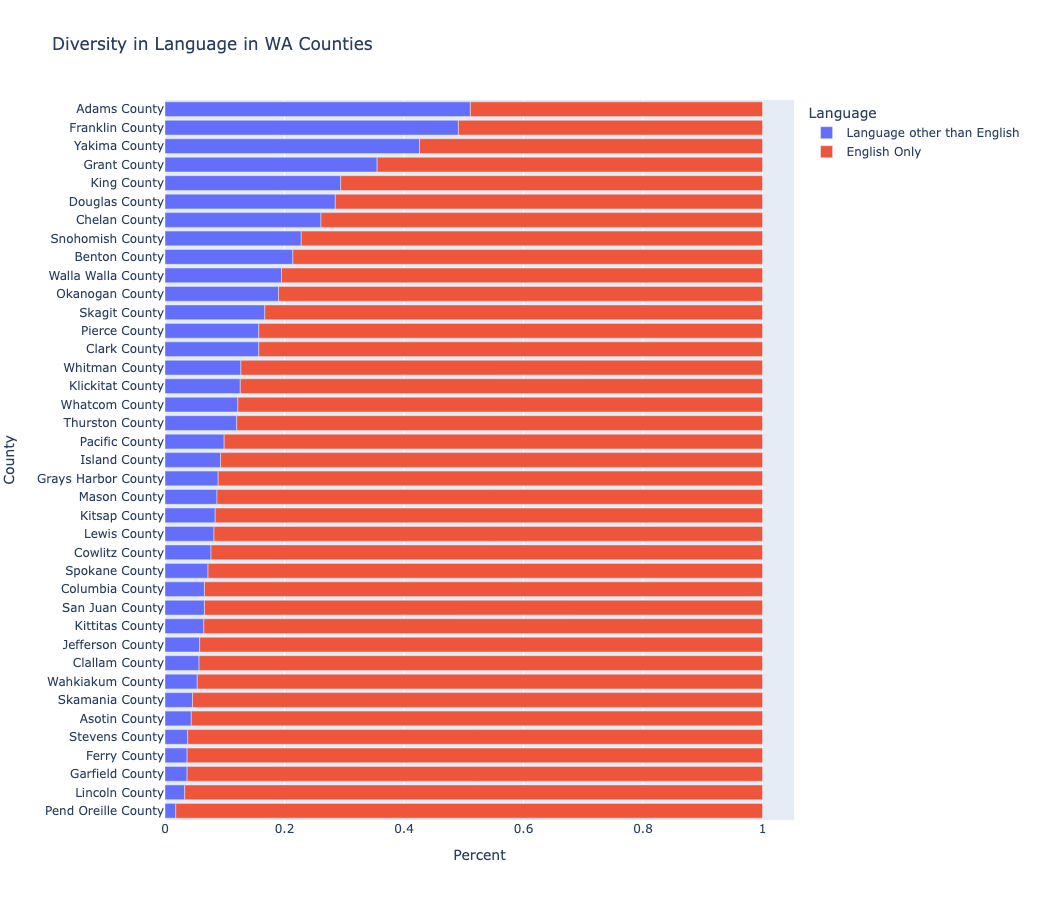

In [17]:
lang_counties = []
lang_counts = []
lang_kind = []
diverse_lang = diverse_lang.iloc[1:, :]

for idx, row in diverse_lang.iterrows():
    lang_counties.append(idx)
    lang_counts.append(row['english_only'])
    lang_kind.append('English Only')
    lang_counties.append(idx)
    lang_counts.append(row['language_other_than_english'])
    lang_kind.append('Language other than English')

lang_data = {}
lang_data['County'] = lang_counties
lang_data['Percent'] = lang_counts
lang_data['Language'] = lang_kind
lang_data = pd.DataFrame(lang_data).sort_values(by='Percent')
fig3 = px.bar(lang_data, x="Percent", y="County", color="Language", title="Diversity in Language in WA Counties", height=900)

fig3.show()
# Testing for proper labeling of counties for each stacked bar
for idx, row in diverse_lang.iterrows():
    plot_index = fig3.to_dict()['data'][0]['y'].tolist().index(idx)
    assert(fig3.to_dict()['data'][0]['x'][plot_index] == diverse_lang.iloc[diverse_lang.index == idx]['language_other_than_english'].iloc[0])
    plot_index = fig3.to_dict()['data'][1]['y'].tolist().index(idx)
    assert(fig3.to_dict()['data'][1]['x'][plot_index] == diverse_lang.iloc[diverse_lang.index == idx]['english_only'].iloc[0])

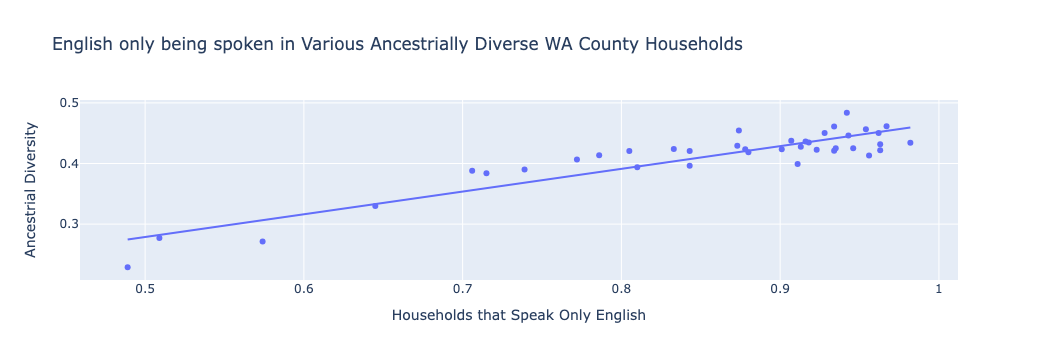

In [18]:
# let's test the strength of the relationships of the two variables: 
# diversity in each county and english only being spoken in households
fig4 = px.scatter(diverse_lang, y='diversity_ratio', x='english_only', trendline='ols', 
                    title='English only being spoken in Various Ancestrially Diverse WA County Households',
                    labels=dict(diversity_ratio="Ancestrial Diversity", english_only="Households that Speak Only English"))
fig4.show()

# Testing for all data points to be on the plot
assert sorted(fig4.to_dict()['data'][0]['x']) == sorted(diverse_lang['english_only'].tolist()), "Data points do not match expected"

In [19]:
X = diverse_lang['english_only']
Y = diverse_lang['diversity_ratio']
X = sm.add_constant(X)
m = sm.OLS(Y.astype(float), X.astype(float))

r = m.fit()
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        diversity_ratio   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     177.1
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           1.12e-15
Time:                        16:31:28   Log-Likelihood:                 94.625
No. Observations:                  39   AIC:                            -185.3
Df Residuals:                      37   BIC:                            -181.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0909      0.024      3.736      0.001       0.042       0.140
english_only     0.3754      0.028     13.307      0.000       0.318       0.433
==============================================================================
Omnibus:                        1.297   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                1.044
Skew:                          -0.155   Prob(JB):                        0.593
Kurtosis:                       2.261   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
sm.tools.eval_measures.mse(diverse_lang['english_only'], diverse_lang['diversity_ratio'], axis=0)

0.2018831402946772